In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal.metadata.xlsx
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/README.md.txt
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-173.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-334.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-309.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-487.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-178.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-10.png
/kaggle/input/tuberculos

In [2]:
!pip install mplcyberpunk
!pip install split-folders

import pathlib, os, random, mplcyberpunk
import splitfolders
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import BatchNormalization, Dense, Dropout, Flatten, MaxPool2D, Conv2D, Activation

In [3]:
base_path = r'/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/'
base_path = pathlib.Path(base_path)
base_path

PosixPath('/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database')

In [4]:
splitfolders.ratio(base_path, output='X_ray_Imgs', seed=123, ratio=(0.7, 0.15, 0.15),
                  group_prefix=None)

Copying files: 4200 files [00:33, 127.19 files/s]


In [5]:
# necessary libraries
import os
import pandas as pd

# visualizations libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
%matplotlib inline

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

# model evaluation libraries
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

from glob import glob
import os
import numpy as np
import pandas as pd
import random
from skimage.io import imread

import matplotlib.pyplot as plt
%matplotlib inline

from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalMaxPooling2D


In [6]:
batch_size = 20
img_height, img_width = 200, 200
input_shape = (img_height, img_width, 3)

datagen= ImageDataGenerator(rescale=1/255)

train_data = datagen.flow_from_directory('X_ray_Imgs/train', target_size=(200, 200),
                                      batch_size=batch_size, class_mode='categorical', subset='training')

test_data = datagen.flow_from_directory('X_ray_Imgs/test', target_size=(200, 200),
                                      batch_size=batch_size, class_mode='categorical', shuffle=False)

val_data = datagen.flow_from_directory('X_ray_Imgs/val/', target_size=(200, 200),
                                      batch_size=batch_size, class_mode='categorical', shuffle=False)

Found 2939 images belonging to 2 classes.
Found 631 images belonging to 2 classes.
Found 630 images belonging to 2 classes.


In [7]:
# generating training data
print("training data :")
train_datagen= ImageDataGenerator(rescale=1/255, zoom_range=0.3, rotation_range=50, width_shift_range= 0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest', validation_split = 0.2)

train_data = train_datagen.flow_from_directory(base_path, 
                                              target_size= (75, 75),
                                              class_mode= "binary",
                                              batch_size=20,
                                              subset= "training"
                                              )

# genarating validation data
print("\nvalidation data :")
val_datagen= ImageDataGenerator(rescale= 1/255, validation_split= 0.2)

val_data= val_datagen.flow_from_directory(base_path, 
                                              target_size= (75, 75),
                                              class_mode= "binary",
                                              batch_size=20,
                                              shuffle= False,
                                              subset= "validation"
                                              )

training data :
Found 3360 images belonging to 2 classes.

validation data :
Found 840 images belonging to 2 classes.


In [8]:
class_names=train_data.class_indices
li=list(class_names)
li

['Normal', 'Tuberculosis']

In [9]:
# inceptionV3 model, with include_top= False we are not using fully connected layer of the inceptionV3 model, instead we
#  will create our own Fully Connected and Output Layer according to our training data
inception_model= InceptionV3(input_shape= (75, 75,3), include_top= False, weights="imagenet")

# Since we are creating our own fully connected layer we need output of the last inception model layer and flatten them 
last_output= inception_model.layers[-1].output

# Flattening the last output
last_output= Flatten()(last_output)

# Our pretrained model
pretrained_model= Model(inception_model.input, last_output)

87910968/87910968 [==============================] - 1s 0us/step


In [10]:
pretrained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[0][0]']

In [11]:
# layer 1
num_classes=2
x= Dense(units=512, activation="relu")(last_output)
x=Dropout(0.2)(x)

# layer 2
x= Dense(units=128, activation="relu")(x)
x=Dropout(0.2)(x)

# output layer
x= Dense(units=1, activation="sigmoid")(x)


# x=Dense(num_classes, activation='softmax')(x) #####


# final model
model= Model(pretrained_model.input, x)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[0][0]

In [12]:
# compile model
model.compile(loss="binary_crossentropy", optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=["accuracy"])

# Since the layers of InceptionV3 model are already trained, we don't want them to be trained again. 
# So we will freeze these layers
for layer in pretrained_model.layers:
    layer.trainable= False

# model fitting
history= model.fit(train_data,
                   steps_per_epoch= train_data.samples//train_data.batch_size,
                   validation_data= val_data,
                   validation_steps= val_data.samples//val_data.batch_size,
                   epochs= 10,
                   verbose=1 
                  )

Epoch 1/10
168/168 [==============================] - 69s 298ms/step - loss: 0.2558 - accuracy: 0.9092 - val_loss: 0.4184 - val_accuracy: 0.8512
Epoch 2/10
168/168 [==============================] - 51s 303ms/step - loss: 0.1737 - accuracy: 0.9396 - val_loss: 0.3827 - val_accuracy: 0.9107
Epoch 3/10
168/168 [==============================] - 48s 283ms/step - loss: 0.1214 - accuracy: 0.9598 - val_loss: 0.5276 - val_accuracy: 0.9036
Epoch 4/10
168/168 [==============================] - 47s 280ms/step - loss: 0.1443 - accuracy: 0.9539 - val_loss: 3.4942 - val_accuracy: 0.9417
Epoch 5/10
168/168 [==============================] - 47s 282ms/step - loss: 0.1238 - accuracy: 0.9649 - val_loss: 2.7215 - val_accuracy: 0.9417
Epoch 6/10
168/168 [==============================] - 47s 282ms/step - loss: 0.1169 - accuracy: 0.9625 - val_loss: 6.4959 - val_accuracy: 0.9369
Epoch 7/10
168/168 [==============================] - 47s 281ms/step - loss: 0.1032 - accuracy: 0.9685 - val_loss: 0.0964 - val_ac

In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

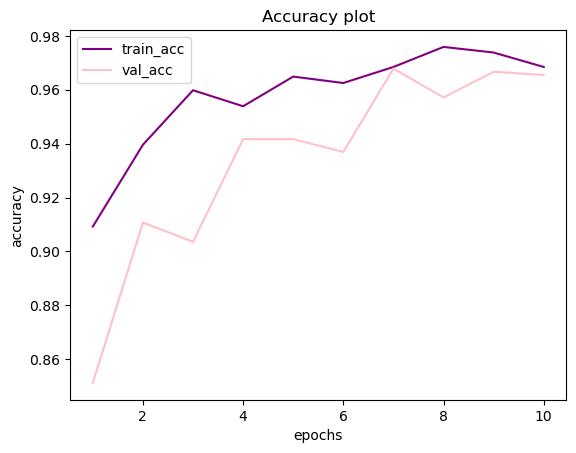

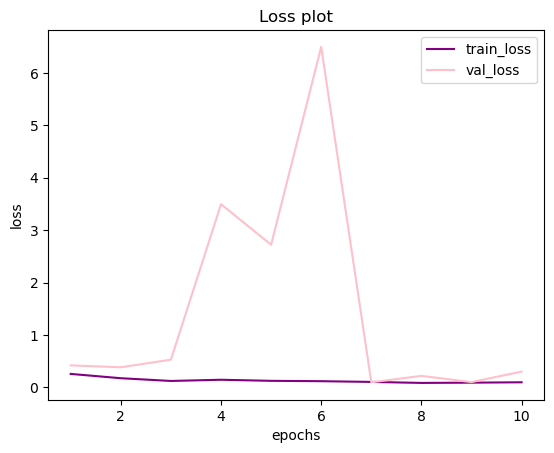

In [14]:
epochs= range(1, len(history.history["accuracy"])+1)

plt.plot(epochs, history.history["accuracy"], color="purple")
plt.plot(epochs, history.history["val_accuracy"], color="pink")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy plot")
plt.legend(["train_acc", "val_acc"])
plt.show()

plt.plot(epochs, history.history["loss"], color="purple")
plt.plot(epochs, history.history["val_loss"], color="pink")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss plot")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [15]:
import numpy as np
prediction= model.predict(val_data, steps=np.ceil(val_data.samples/val_data.batch_size), verbose=2)
prediction= (prediction > 0.5)
prediction

42/42 - 9s - 9s/epoch - 220ms/step


array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [16]:
val_labels=val_data.classes
val_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
prediction.shape

(840, 1)

In [18]:
val_labels.shape

(840,)

0.9654761904761905
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       700
           1       0.97      0.81      0.89       140

    accuracy                           0.97       840
   macro avg       0.97      0.91      0.93       840
weighted avg       0.97      0.97      0.96       840



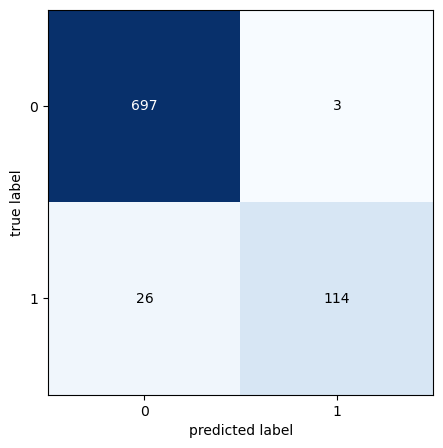

In [19]:
cm= confusion_matrix(val_data.classes, prediction)
plot_confusion_matrix(cm, figsize=(5,5))

print(accuracy_score(val_data.classes, prediction))
print(classification_report(val_data.classes, prediction))

In [20]:
# Importing the metrics package from sklearn library
from sklearn import metrics
# Creating the confusion matrix
cm = metrics.confusion_matrix(val_data.classes, prediction)
# Assigning columns names
cm_df = pd.DataFrame(cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
# Showing the confusion matrix
cm_df

,Predicted Negative,Predicted Positive
Actual Negative,697,3
Actual Positive,26,114


In [21]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')
    
confusion_metrics(cm)

True Positives: 114
True Negatives: 697
False Positives: 3
False Negatives: 26
--------------------------------------------------
Accuracy: 0.97
Mis-Classification: 0.03
Sensitivity: 0.81
Specificity: 1.0
Precision: 1.0
f_1 Score: 0.9


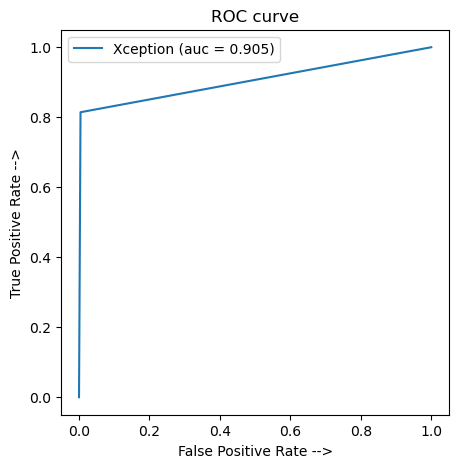

In [22]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(val_data.classes, prediction)
auc_inception = auc(fpr, tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr, tpr, linestyle='-', label='Xception (auc = %0.3f)' % auc_inception)


plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()
plt.title("ROC curve")
plt.show()